## Topic Assignment Study

This notebook assigns each topic generated from the LDA and BERTopic approaches to a subset of the data and then to the entire sample data.

## 16 Topics Labels with associated list of words:

###Topics###
1. **Pediatric Mental Health Assessment**: student, participant, survey, mental, online, anxiety, education, child, self, psychological
2. **Vaccine Immunology & Surveillance**: vaccine, vaccination, antibody, variant, transmission, influenza, testing, assay, detection, detect
3. **Environmental Exposure and Contamination**: mask, food, air, concentration, surface, energy, water, temperature, material, environmental
4. **Global Economic Crisis Policy**: policy, article, service, community, crisis, economic, global, management, paper, world
5. **Pediatric COVID-19 Outcomes**: ci, mortality, p, death, trial, child, admission, severity, cohort, covid
6. **Molecular Therapeutics and Immunomodulation**: protein, drug, immune, target, gene, expression, receptor, mechanism, induce, therapeutic
7. **Thoracic Oncology and Surgical Outcomes**: cancer, surgery, lung, complication, surgical, pain, procedure, undergo, diagnosis, pulmonary
8. **AI-Driven Medical Imaging Tools**: propose, network, performance, learning, image, application, accuracy, user, predict, tool
9. **Online Education and Learning**: teacher, teaching, learning, learn, student, online, education, university, educational, learner
10. **Pediatric Multisystem Inflammatory Syndrome**: child, pediatric, multisystem, inflammatory, pim, syndrome, infant, adult, fever, ts
11. **Viral Glycan Interactions**: replication, glycan, protein, rna, virus, viral, membrane, glycosylation, virion,host
12. **Deep Learning Chest X-ray Segmentation**: image, ray, deep, segmentation, chest, classification, dataset, convolutional, ct, learning
13. **Global Governance and International Law**: government, governance, law, policy, country, public, global, right, political, international
14. **Protease Inhibitor Compound Design**: protease, docking, compound, inhibitor, mpro, drug, molecular, bind, ligand, pro
15. **Venous Thromboembolism Management**: vte, thrombosis, anticoagulation, embolism, venous, coagulation, thrombotic, thromboembolism, dimer, heparin
16. **Emergency Healthcare Preparedness and Staffing**: hospital, hcw, bed, ambulance, staff, emergency, healthcare, preparedness, care, facility

#### Experiment 1: Sanity Check ####
We will first check if this approach would pick the correct topic list for a given generated topic label.

This gives us the opportunity to check whether the representation of the Generated Label is a suitable reflection of the topic lists from the LDA and BERTopic approaches. The experimental setup is outlined as follows:
*  Encode each Generate Label using a Model design for semantic tasks.
*  Encode each topic list as a 'single sentence' to get an overall representation of each topic list.
*  Use Cosine Smilairty to compare each topic list to each subfiled label.
*  Assign each topic list to a label using argmax.

As word representations from LLms tend to be in a high-dimensional space, PCA will be used to reduce the dimensionality of this data for visualization.

The model `all-MiniLM-L6-v2` was chosen as it is designed to encode sentences for the purpose of semantic searching or clustering making it suitable for this task. [Documentation](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)


#### Experiment 2: Assigning these Generated Labels to a Subset of the Dataset using this Approach####

We will then follow the same approach except instead of assigning a Label to a given topic list, we will be assigning it to a sample of our data. 100 samples have been chosen to test on. Then we will apply this approach to the entire data sample.

**Note**: A Hugging Face user access token is needed for this project. Go to [this](https://huggingface.co/docs/hub/security-tokens) website to set up a Hugging Face Account if needed.

##Experiment 1: Sanity Check##

We will check whether this approach would match the 16 generated topic labels to the correct topic list. We should get the list that is included at the top of this notebook.

In [5]:
#Mounting drive and accessing dataset
from google.colab import drive
drive.mount('/content/drive')
file_path ='/content/drive/My Drive/Semester 2/Data Analytics and Data Mining/Group Project/Notebooks/Final Data Cleaning and EDA/cleaned_datasett.csv' #edit depending on file location
import pandas as pd
df = pd.read_csv(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df.head()

,processed_title,processed_abstract,processed_title_and_abstract
0,population health strategy support hospital in...,country affect number people infect dead first...,population health strategy support hospital in...
1,gis jungle experiential environmental educatio...,travel course build hempel legacy environmenta...,gis jungle experiential environmental educatio...
2,impact american attitude study twitter,past research study social determinant attitud...,impact american attitude study twitter past re...
3,paxlovidtm information guidance member,american society ae official statement provide...,paxlovidtm information guidance member america...
4,upper respiratory tract infection sport immune...,simple summary review clarify relationship hea...,upper respiratory tract infection sport immune...


In [7]:
# set seed for reproducibility
import random
random.seed(42)
#imports
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer # encode each label/sentence
from sklearn.metrics.pairwise import cosine_similarity #to compute similarity between label and list
from sklearn.decomposition import PCA #reduce dimensions for visualization

#Generated Topic Labels
potential_topics_labels = ["Pediatric Mental Health Assessment", "Vaccine Immunology & Surveillance","Environmental Exposure and Contamination","Global Economic Crisis Policy","Pediatric COVID-19 Outcomes","Molecular Therapeutics and Immunomodulation","Thoracic Oncology and Surgical Outcomes","AI-Driven Medical Imaging Tools","Online Education and Learning","Pediatric Multisystem Inflammatory Syndrome","Viral Glycan Interactions","Deep Learning Chest X-ray Segmentation","Global Governance and International Law","Protease Inhibitor Compound Design", "Venous Thromboembolism Management", "Emergency Healthcare Preparedness and Staffing"]

#LDA and BERTopic Results in the form of one string per topic
topic_lists = [
    "student participant survey mental online anxiety education child self psychological",
    "vaccine vaccination antibody variant transmission influenza testing assay detection detect",
    "mask food air concentration surface energy water temperature material environmental",
    "policy article service community crisis economic global management paper world",
    "ci mortality p death trial child admission severity cohort covid",
    "protein drug immune target gene expression receptor mechanism induce therapeutic",
    "cancer surgery lung complication surgical pain procedure undergo diagnosis pulmonary",
    "propose network performance learning image application accuracy user predict tool",
    "teacher teaching learning learn student online education university educational learner",
    "child pediatric multisystem inflammatory pim syndrome infant adult fever ts",
    "replication glycan protein rna virus viral membrane glycosylation virion host",
    "image ray deep segmentation chest classification dataset convolutional ct learning",
    "government governance law policy country public global right political international",
    "protease docking compound inhibitor mpro drug molecular bind ligand pro",
    "vte thrombosis anticoagulation embolism venous coagulation thrombotic thromboembolism dimer heparin",
    "hospital hcw bed ambulance staff emergency healthcare preparedness care facility"
]


#Model to encode the labels and sentences
model = SentenceTransformer('all-MiniLM-L6-v2') #HF Token will be needed

#encode the labels
label_embeddings = np.array([model.encode(label) for label in potential_topics_labels]) #arrays needed to compute cosine similarity

#encode the topic lists
topic_list_embeddings = np.array([model.encode(topic_list) for topic_list in topic_lists])

#assign to label based on cosine
label_subfield_assignments = []
cosine_scores = []

#choosing the topic label with the closest cosine similarity
for topic_embedding in topic_list_embeddings:
    sim = cosine_similarity([topic_embedding], label_embeddings)[0]
    best_label_index = np.argmax(sim)
    label_subfield_assignments.append(potential_topics_labels[best_label_index])
    cosine_scores.append(sim[best_label_index])


#printing
for i, (topic, label, score) in enumerate(zip(topic_lists, label_subfield_assignments, cosine_scores)):
    print(f"Topic {i+1}: {topic}")
    print(f"Assigned Topic Label: {label}")
    print(f"Cosine Similarity Score: {score}\n")


Topic 1: student participant survey mental online anxiety education child self psychological
Assigned Topic Label: Pediatric Mental Health Assessment
Cosine Similarity Score: 0.5213207006454468

Topic 2: vaccine vaccination antibody variant transmission influenza testing assay detection detect
Assigned Topic Label: Vaccine Immunology & Surveillance
Cosine Similarity Score: 0.5622630715370178

Topic 3: mask food air concentration surface energy water temperature material environmental
Assigned Topic Label: Environmental Exposure and Contamination
Cosine Similarity Score: 0.37870144844055176

Topic 4: policy article service community crisis economic global management paper world
Assigned Topic Label: Global Economic Crisis Policy
Cosine Similarity Score: 0.7376996874809265

Topic 5: ci mortality p death trial child admission severity cohort covid
Assigned Topic Label: Pediatric COVID-19 Outcomes
Cosine Similarity Score: 0.5708644986152649

Topic 6: protein drug immune target gene express

<ipython-input-8-97401f44a97a>:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embedding[0], embedding[1], c=label_to_color[label], label=label if label not in plt.gca().get_legend_handles_labels()[1] else "", alpha=0.6)


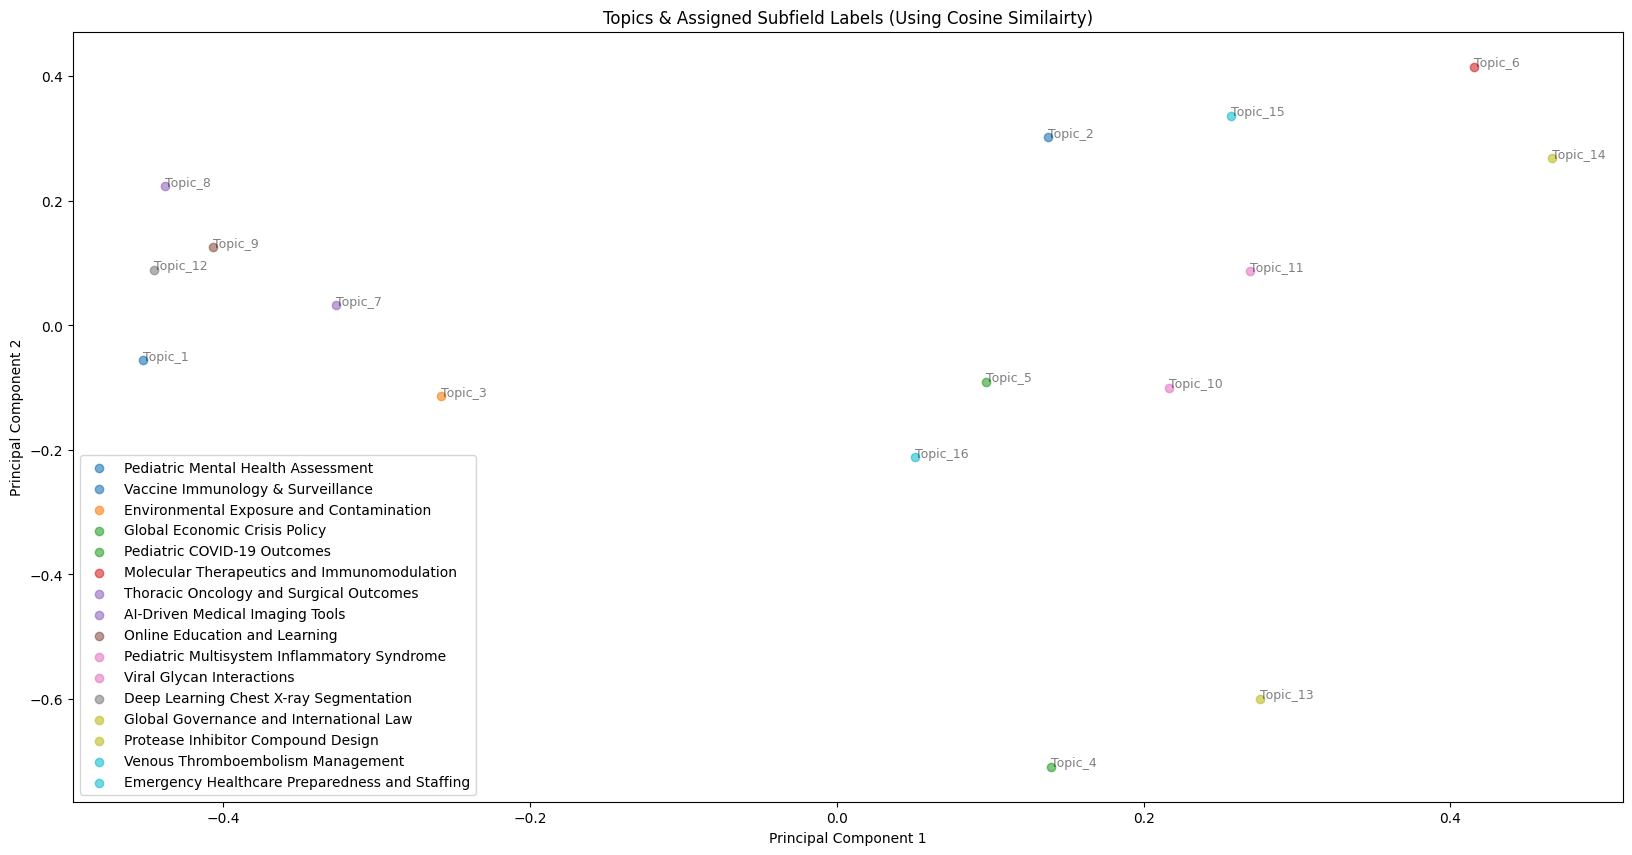

In [8]:
#Reducing Dimensionality for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(topic_list_embeddings)

#plotting
plt.figure(figsize=(20, 10))
colours = plt.get_cmap("tab10", len(potential_topics_labels))
label_to_color = {label: colours(i) for i, label in enumerate(potential_topics_labels)}


#scatter plot with colour matching subfield
for i, (embedding, label) in enumerate(zip(reduced_embeddings, label_subfield_assignments)):
    plt.scatter(embedding[0], embedding[1], c=label_to_color[label], label=label if label not in plt.gca().get_legend_handles_labels()[1] else "", alpha=0.6)
    plt.text(embedding[0], embedding[1],f'Topic_{i+1}', fontsize=9, alpha=0.5)
plt.legend()
plt.title("Topics & Assigned Subfield Labels (Using Cosine Similairty)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()



As can be seen, it correctly matches the topics which were generated from the topic lists. We can now move onto experiemnt 2.

## Experiment 2: Assigning Topic Labels to the CORD-19 Dataset
Trying on 100 samples of the dataset


In [12]:
#create a small dataset that is the first 100 samples from 'processed abstracts and titles'
df_subset = df[['processed_title_and_abstract']].head(100)

df_subset.tail()

,processed_title_and_abstract
95,analysis real time oncology review rtor pilot ...
96,transmembrane serine protease potential target...
97,malaria burden amerindian group venezuelan sta...
98,risk factor associate hospitalization associat...
99,experience open school preschool period high c...


In [13]:
#Generated Topic Labels
potential_topics_labels = ["Pediatric Mental Health Assessment", "Vaccine Immunology & Surveillance","Environmental Exposure and Contamination","Global Economic Crisis Policy","Pediatric COVID-19 Outcomes","Molecular Therapeutics and Immunomodulation","Thoracic Oncology and Surgical Outcomes","AI-Driven Medical Imaging Tools","Online Education and Learning","Pediatric Multisystem Inflammatory Syndrome","Viral Glycan Interactions","Deep Learning Chest X-ray Segmentation","Global Governance and International Law","Protease Inhibitor Compound Design", "Venous Thromboembolism Management", "Emergency Healthcare Preparedness and Staffing"]

#LDA and BERTopic Results in the form of one string per topic
topic_lists = df_subset['processed_title_and_abstract'].to_list()

#Model to encode the labels and sentences
model = SentenceTransformer('all-MiniLM-L6-v2')

#encode the labels
label_embeddings = np.array([model.encode(label) for label in potential_topics_labels]) #arrays needed to compute cosine similarity

#encode the topic lists
topic_list_embeddings = np.array([model.encode(topic_list) for topic_list in topic_lists])

#assign to label based on cosine
label_subfield_assignments = []
cosine_scores = []


for topic_embedding in topic_list_embeddings:
    sim = cosine_similarity([topic_embedding], label_embeddings)[0]
    best_label_index = np.argmax(sim)
    label_subfield_assignments.append(potential_topics_labels[best_label_index])
    cosine_scores.append(sim[best_label_index])


#printing
for i, (topic, label, score) in enumerate(zip(topic_lists, label_subfield_assignments, cosine_scores)):
    print(f"Topic {i+1}: {topic}")
    print(f"Assigned Topic Label: {label}")
    print(f"Cosine Similarity Score: {score}\n")



Topic 1: population health strategy support hospital intensive care unit resiliency pandemic italian experience country affect number people infect dead first wave describe rapid rollout population health clinical organizational response preparedness capability support first wave pandemic italian province review process challenge face describe excess demand hospital service successfully mitigate thus overwhelm healthcare service avoid collapse local health care system analysis bed occupancy region predict first week epidemic seir model estimate number infected people different containment measure community resource mobilize reduce provincial hospital burden care population health approach base radical reorganization workflow emergency patient management implement bed saturation measure newly implement intensive care unit bed occupancy centralized governance dashboard bed occupancy increase avoid saturation system region achieve high rate icu bed availability icu bed inhabitant compare 

In [14]:
df_subset.head()

,processed_title_and_abstract
0,population health strategy support hospital in...
1,gis jungle experiential environmental educatio...
2,impact american attitude study twitter past re...
3,paxlovidtm information guidance member america...
4,upper respiratory tract infection sport immune...


In [15]:
#add the results to the dataframe to allow further testing.
df_subset['Assigned Topic'] = label_subfield_assignments
df_subset['Cosine Similarity'] = cosine_scores

In [17]:
df_subset.head(10)

,processed_title_and_abstract,Assigned Topic,Cosine Similarity
0,population health strategy support hospital in...,Emergency Healthcare Preparedness and Staffing,0.516961
1,gis jungle experiential environmental educatio...,Online Education and Learning,0.290159
2,impact american attitude study twitter past re...,Global Economic Crisis Policy,0.235674
3,paxlovidtm information guidance member america...,Venous Thromboembolism Management,0.313143
4,upper respiratory tract infection sport immune...,Vaccine Immunology & Surveillance,0.323884
5,assess epidemic potential viruse many new emer...,Vaccine Immunology & Surveillance,0.413619
6,race get ready coronavirus spread country nati...,Pediatric COVID-19 Outcomes,0.454708
7,identification novel protein encode latency re...,Viral Glycan Interactions,0.315365
8,workbench probe lipidomic landscape target lip...,Protease Inhibitor Compound Design,0.213880
9,informal caregiver support need burden survey ...,Emergency Healthcare Preparedness and Staffing,0.279120


In [18]:
#sort using highest cosine similarity
df_subset.sort_values(by='Cosine Similarity', ascending=False, inplace=True)
df_subset.head(10)

,processed_title_and_abstract,Assigned Topic,Cosine Similarity
50,vaccine editorial,Vaccine Immunology & Surveillance,0.730401
23,clinical feature patient venous thromboembolis...,Venous Thromboembolism Management,0.567525
39,minority child early national surge pandemic b...,Pediatric COVID-19 Outcomes,0.517886
0,population health strategy support hospital in...,Emergency Healthcare Preparedness and Staffing,0.516961
75,crude polysaccharide syzygium aromaticum sar a...,Viral Glycan Interactions,0.488620
22,allergic reaction vaccine evidence practice or...,Vaccine Immunology & Surveillance,0.484097
72,polyp unaffected chronic exposure combination ...,Environmental Exposure and Contamination,0.478326
6,race get ready coronavirus spread country nati...,Pediatric COVID-19 Outcomes,0.454708
49,medicinal therapeutic potential withanolide so...,Molecular Therapeutics and Immunomodulation,0.452846
13,influence learn health system address pandemic...,Emergency Healthcare Preparedness and Staffing,0.448875


Try with 100,000 Dataset


In [22]:
#save df_subset as csv before trying on whole dataset
df_subset.to_csv('df_subset.csv', index=False)

#download
from google.colab import files
files.download('df_subset.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
#create a copy of original df as backup
df_copy = df.copy()

In [24]:
#Generated Topic Labels
potential_topics_labels = ["Pediatric Mental Health Assessment", "Vaccine Immunology & Surveillance","Environmental Exposure and Contamination","Global Economic Crisis Policy","Pediatric COVID-19 Outcomes","Molecular Therapeutics and Immunomodulation","Thoracic Oncology and Surgical Outcomes","AI-Driven Medical Imaging Tools","Online Education and Learning","Pediatric Multisystem Inflammatory Syndrome","Viral Glycan Interactions","Deep Learning Chest X-ray Segmentation","Global Governance and International Law","Protease Inhibitor Compound Design", "Venous Thromboembolism Management", "Emergency Healthcare Preparedness and Staffing"]

#LDA and BERTopic Results in the form of one string per topic
topic_lists = df['processed_title_and_abstract'].astype(str).to_list() #str as it encounters floats in full dataset

#Model to encode the labels and sentences
model = SentenceTransformer('all-MiniLM-L6-v2')

#encode the labels
label_embeddings = np.array([model.encode(label) for label in potential_topics_labels]) #arrays needed to compute cosine similarity

#encode the topic lists
topic_list_embeddings = np.array([model.encode(topic_list) for topic_list in topic_lists])

#assign to label based on cosine
label_subfield_assignments = []
cosine_scores = []


for topic_embedding in topic_list_embeddings:
    sim = cosine_similarity([topic_embedding], label_embeddings)[0]
    best_label_index = np.argmax(sim)
    label_subfield_assignments.append(potential_topics_labels[best_label_index])
    cosine_scores.append(sim[best_label_index])


#printing
for i, (topic, label, score) in enumerate(zip(topic_lists, label_subfield_assignments, cosine_scores)):
    print(f"Topic {i+1}: {topic}")
    print(f"Assigned Topic Label: {label}")
    print(f"Cosine Similarity Score: {score}\n")


#add the results to the dataframe to allow further testing.
df['Assigned Topic'] = label_subfield_assignments
df['Cosine Similarity'] = cosine_scores


#sort using highest cosine similarity
df.sort_values(by='Cosine Similarity', ascending=False, inplace=True)
df.head(10)



#save df as csv for further eval
df.to_csv('df_annotated.csv', index=False)


#download
files.download('df_annotated.csv')

Streaming output truncated to the last 5000 lines.
Topic 98751: joint hierarchical model number case death borough montreal epicentre pandemic high number death country cumulative number case death 25th record area montreal model bivariate hierarchical bayesian model poisson distribution poisson mean decompose log scale sum fix effect latent effect areal median age educational level number bed long term care home include fix effect explore correlation case death area area bivariate model consider latent effect namely independent one conditional autoregressive model one allow spatially structure unstructured source variability inclusion spatial effect change fix effect extend spatial approach bayesian areal set investigate presence spatial confound result show cumulative total case death negatively correlate inside borough montreal covariate associate similar manner case death educational level median age spatially confound case death borough montreal
Assigned Topic Label: Pediatric COV

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
df_subset.head()

,processed_title_and_abstract,Assigned Topic,Cosine Similarity
50,vaccine editorial,Vaccine Immunology & Surveillance,0.730401
23,clinical feature patient venous thromboembolis...,Venous Thromboembolism Management,0.567525
39,minority child early national surge pandemic b...,Pediatric COVID-19 Outcomes,0.517886
0,population health strategy support hospital in...,Emergency Healthcare Preparedness and Staffing,0.516961
75,crude polysaccharide syzygium aromaticum sar a...,Viral Glycan Interactions,0.488620
